# Automated Machine Learning
_**Classification of credit card fraudulent transactions on remote compute **_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Train](#Train)
1. [Results](#Results)
1. [Test](#Test)
1. [Acknowledgements](#Acknowledgements)

## Introduction

In this example we use the associated credit card dataset to showcase how you can use AutoML for a simple classification problem. The goal is to predict if a credit card transaction is considered a fraudulent charge.

This notebook is using remote compute to train the model.

If you are using an Azure Machine Learning Compute Instance, you are all set. Otherwise, go through the [configuration](../../../configuration.ipynb) notebook first if you haven't already to establish your connection to the AzureML Workspace. 

In this notebook you will learn how to:
1. Create an experiment using an existing workspace.
2. Configure AutoML using `AutoMLConfig`.
3. Train the model using remote compute.
4. Explore the results.
5. Test the fitted model.

## Setup

As part of the setup you have already created an Azure ML `Workspace` object. For Automated ML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import logging

from matplotlib import pyplot as plt
import pandas as pd
import os

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig

This sample notebook may use features that are not available in previous versions of the Azure ML SDK.

In [2]:
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = "automl-classification-ccard-remote"

experiment = Experiment(ws, experiment_name)

output = {}
output["Subscription ID"] = ws.subscription_id
output["Workspace"] = ws.name
output["Resource Group"] = ws.resource_group
output["Location"] = ws.location
output["Experiment Name"] = experiment.name
output["SDK Version"] = azureml.core.VERSION
pd.set_option("display.max_colwidth", None)
outputDf = pd.DataFrame(data=output, index=[""])
outputDf.T

,
Subscription ID,dac8073e-1c2d-4a7d-a53b-c3655e291d58
Workspace,learningmain
Resource Group,learning
Location,eastus
Experiment Name,automl-classification-ccard-remote
SDK Version,1.48.0


## Create or Attach existing AmlCompute
A compute target is required to execute the Automated ML run. In this tutorial, you create AmlCompute as your training compute resource.

> Note that if you have an AzureML Data Scientist role, you will not have permission to create compute resources. Talk to your workspace or IT admin to create the compute targets described in this section, if they do not already exist.

#### Creation of AmlCompute takes approximately 5 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

In [3]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "cpu-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print("Found existing cluster, use it.")
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="STANDARD_DS12_V2", max_nodes=6
    )
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)
compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


# Data

### Load Data

Load the credit card dataset from a csv file containing both training features and labels. The features are inputs to the model, while the training labels represent the expected output of the model. Next, we'll split the data using random_split and extract the training data for the model.

In [4]:
data = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/creditcard.csv"
dataset = Dataset.Tabular.from_delimited_files(data)
training_data, validation_data = dataset.random_split(percentage=0.8, seed=223)
label_column_name = "Class"

## Train

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**enable_early_stopping**|Stop the run if the metric score is not showing improvement.|
|**n_cross_validations**|Number of cross validation splits.|
|**training_data**|Input dataset, containing both features and label column.|
|**label_column_name**|The name of the label column.|

**_You can find more information about primary metrics_** [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train#primary-metric)

In [5]:
automl_settings = {
    "n_cross_validations": 3,
    "primary_metric": "average_precision_score_weighted",
    "enable_early_stopping": True,
    "max_concurrent_iterations": 2,  # This is a limit for testing purpose, please increase it as per cluster size
    "experiment_timeout_hours": 0.25,  # This is a time limit for testing purposes, remove it for real use cases, this will drastically limit ablity to find the best model possible
    "verbosity": logging.INFO,
}

automl_config = AutoMLConfig(
    task="classification",
    debug_log="automl_errors.log",
    compute_target=compute_target,
    training_data=training_data,
    label_column_name=label_column_name,
    **automl_settings,
)

Call the `submit` method on the experiment object and pass the run configuration. Depending on the data and the number of iterations this can run for a while. Validation errors and current status will be shown when setting `show_output=True` and the execution will be synchronous.

In [6]:
remote_run = experiment.submit(automl_config, show_output=False)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-classification-ccard-remote,AutoML_90c1c2ec-5239-47b5-bd31-54e7a3de6620,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [7]:
# If you need to retrieve a run that already started, use the following code
# from azureml.train.automl.run import AutoMLRun
# remote_run = AutoMLRun(experiment = experiment, run_id = '<replace with your run id>')

## Results

#### Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details

In [8]:
from azureml.widgets import RunDetails

RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [9]:
remote_run.wait_for_completion(show_output=False)

{'runId': 'AutoML_90c1c2ec-5239-47b5-bd31-54e7a3de6620',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2023-03-07T16:12:00.475463Z',
 'endTimeUtc': '2023-03-07T16:39:35.40586Z',
 'services': {},
 'warnings': [{'source': 'JasmineService',
   'message': 'Experiment timeout reached, hence experiment stopped. Current experiment timeout: 0 hour(s) 15 minute(s)'}],
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'average_precision_score_weighted',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'cpu-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-classification-ccard-remote","subscription_id":"dac8073e-1c2d-4a7d-a53b-c3655e291d58","resource_group":"learning","workspace_name":"learningmain","region":"eastus","compute_target":"cpu-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch

#### Explain model

Automated ML models can be explained and visualized using the SDK Explainability library. 

## Analyze results

### Retrieve the Best Model

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [10]:
best_run, fitted_model = remote_run.get_output()
fitted_model

PipelineWithYTransformations(Pipeline={'memory': None,
                                       'steps': [('datatransformer',
                                                  DataTransformer(enable_dnn=False, enable_feature_sweeping=True, feature_sweeping_config={}, feature_sweeping_timeout=86400, featurization_config=None, force_text_dnn=False, is_cross_validation=True, is_onnx_compatible=False, observer=None, task='classification', working_dir='/mn...
                                                  PreFittedSoftVotingClassifier(classification_labels=array([0, 1]), estimators=[('7', Pipeline(memory=None, steps=[('standardscalerwrapper', StandardScalerWrapper(copy=True, with_mean=True, with_std=False)), ('logisticregression', LogisticRegression(C=339.3221771895323, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='multinomial', n_jobs=1, penalty='l2', random_state=None, solver='lbfgs', tol=0.0001, verbose=0, warm_start=Fa

#### Print the properties of the model
The fitted_model is a python object and you can read the different properties of the object.


## Test the fitted model

Now that the model is trained, split the data in the same way the data was split for training (The difference here is the data is being split locally) and then run the test data through the trained model to get the predicted values.

In [11]:
# convert the test data to dataframe
X_test_df = validation_data.drop_columns(
    columns=[label_column_name]
).to_pandas_dataframe()
y_test_df = validation_data.keep_columns(
    columns=[label_column_name], validate=True
).to_pandas_dataframe()

In [12]:
# call the predict functions on the model
y_pred = fitted_model.predict(X_test_df)
y_pred

array([False, False, False, ..., False, False, False])

### Calculate metrics for the prediction

Now visualize the data on a scatter plot to show what our truth (actual) values are compared to the predicted values 
from the trained model that was returned.

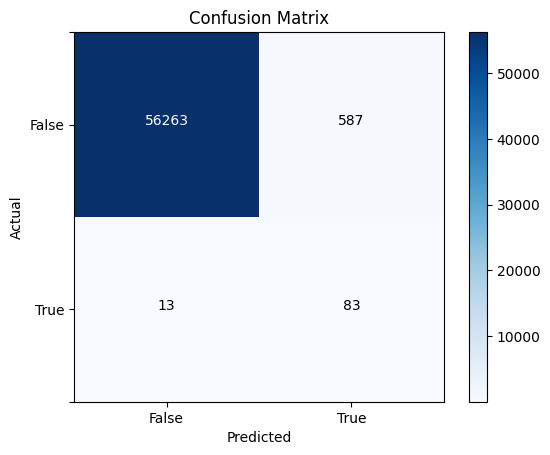

In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf = confusion_matrix(y_test_df.values, y_pred)
plt.imshow(cf, cmap=plt.cm.Blues, interpolation="nearest")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
class_labels = ["False", "True"]
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks([-0.5, 0, 1, 1.5], ["", "False", "True", ""])
# plotting text value inside cells
thresh = cf.max() / 2.0
for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
    plt.text(
        j,
        i,
        format(cf[i, j], "d"),
        horizontalalignment="center",
        color="white" if cf[i, j] > thresh else "black",
    )
plt.show()

## Acknowledgements

This Credit Card fraud Detection dataset is made available under the Open Database License: http://opendatacommons.org/licenses/odbl/1.0/. Any rights in individual contents of the database are licensed under the Database Contents License: http://opendatacommons.org/licenses/dbcl/1.0/ and is available at: https://www.kaggle.com/mlg-ulb/creditcardfraud

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (UniversitÃ© Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

Please cite the following works:

Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-AÃ«l; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-AÃ«l; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

Bertrand Lebichot, Yann-AÃ«l Le Borgne, Liyun He, Frederic OblÃ©, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

Fabrizio Carcillo, Yann-AÃ«l Le Borgne, Olivier Caelen, Frederic OblÃ©, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019